<a href="https://colab.research.google.com/github/carlosperez1997/flight_delay_prediction/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

TFM: 
Developed by: Carlos Pérez Ricardo


In [ ]:
!pip install psutil
!pip install humanize

In [ ]:
import os, humanize, psutil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

In [ ]:
mem_report()

CPU RAM Free: 12.5 GB


In [ ]:
def date_features(df, col):
    df[col] = pd.to_datetime(df[col])
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df['year'] = df[col].dt.year
    df['FL_DATE_quarter'] = df['FL_DATE'].dt.quarter
    df['weekday'] = df[col].dt.weekday
    df['year_month'] = [ str(y)+'_'+str(m) if m < 10 else str(y)+'_0'+str(m) for y, m in zip(df['year'], df['month']) ]
    df['year_week'] = df[col].dt.strftime('%Y%V')

    return df

In [ ]:
# Add flight distance in km
def flight_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = lat1 * math.pi/180
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    
    a = np.sin(delta_phi/2) * np.sin(delta_lambda/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return np.round(R * c) # in kilometres

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        try:
            if col_type != object:
                
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        except:
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basics
import pandas as pd
import numpy as np
import time
import os
from os import listdir
from os.path import isfile, join, basename
from tqdm import tqdm
from timeit import timeit
import gc
from sys import getsizeof

import math
import sys
import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [ ]:
DIR = '/Users/carlosperezricardo/Desktop/TFM'
DIR = '/content/drive/MyDrive/TFM'

AIRPORT = 10397
years_to_load = ['2017','2018','2019']

Importing dataset

In [ ]:
folder = os.path.join(DIR, 'datasets')
files = [f for f in listdir(folder) if isfile(join(folder, f))]
files = sorted(files)

In [ ]:
if os.path.exists(os.path.join(DIR, 'df_all.pkl')):
    df = pd.read_pickle(os.path.join(DIR, 'df_all.pkl'))
else:
    df = pd.DataFrame()
    for file in files:
        loading = []
        if '.zip' in file:
            for year in years_to_load:
                loading.append(year in file)
            output = any(loading)
            if output:
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file), parse_dates=['FL_DATE'])
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file))
                add_df = reduce_mem_usage(add_df)
                df = pd.concat([df, add_df], axis=0)
                del add_df
    df.reset_index(drop=True, inplace=True)
    del df['Unnamed: 29']
    df.to_pickle(os.path.join(DIR, 'df_all.pkl'))

In [ ]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
0,2017-01-01,AA,19805,AA,N3GNAA,2186,14100,1410002,34100,PHL,...,-5.0,731.0,-19.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,AA,N3KAAA,2189,11298,1129804,30194,DFW,...,2.0,2023.0,-4.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,AA,N3LFAA,2190,11298,1129804,30194,DFW,...,0.0,4.0,16.0,0.0,NaN,0.0,0.0,0.0,16.0,0.0
3,2017-01-01,AA,19805,AA,N3DDAA,2191,11697,1169704,32467,FLL,...,-2.0,1528.0,-10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,AA,N3HLAA,2192,11278,1127803,30852,DCA,...,2.0,2052.0,12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [ ]:
df = date_features(df, 'FL_DATE')

In [ ]:
df = reduce_mem_usage(df)

# Univariate Analysis

## Time variables

In [ ]:
df = df[(df.DEP_DELAY.isnull() == False) & (df.ARR_DELAY.isnull() == False)]

In [ ]:
df['DEP_TIME_hour'] = df['DEP_TIME'].apply(lambda x: math.trunc(x)/100).astype(int)
df['ARR_TIME_hour'] = df['ARR_TIME'].apply(lambda x: math.trunc(x)/100).astype(int)

df.loc[df.DEP_TIME_hour == 24, 'DEP_TIME_hour'] = 0
df.loc[df.ARR_TIME_hour == 24, 'ARR_TIME_hour'] = 0

In [ ]:
time_vars = ['FL_DATE','month','day','year','FL_DATE_quarter','weekday','year_month','year_week','DEP_TIME_hour','ARR_TIME_hour']

In [ ]:
for col in time_vars:
    df[col] = df[col].astype('category')

df[time_vars].describe()

,FL_DATE,month,day,year,FL_DATE_quarter,weekday,year_month,year_week,DEP_TIME_hour,ARR_TIME_hour
count,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460,19919460
unique,1095,12,31,3,4,7,36,156,24,24
top,2019-08-05 00:00:00,7,26,2019,3,4,2019_8,201901,6,16
freq,22278,1776747,666850,7268232,5163166,2973017,645351,150528,1285738,1228472


## Numerical variables

In [ ]:
numerical_vars = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']

In [ ]:
desc = pd.DataFrame()
for col in numerical_vars:
    #df[col].fillna(0, inplace=True)
    x = df.loc[df[col].isnull() == False, col]
    y = x.describe().astype('float16')
    y['count'] = len(x)/10000
    y['mean'] = x.astype(int).mean()
    y['std'] = x.astype(int).std()

    desc = pd.concat([desc, y], axis=1)

In [ ]:
desc

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
count,1992.000000,1992.000000,377.000000,377.000000,377.00000,377.000000
mean,10.179688,4.984375,20.203125,3.447266,16.18750,26.171875
std,45.937500,48.187500,62.562500,29.500000,37.34375,50.625000
min,-234.000000,-238.000000,0.000000,0.000000,0.00000,0.000000
25%,-5.000000,-15.000000,0.000000,0.000000,0.00000,0.000000
50%,-2.000000,-6.000000,0.000000,0.000000,2.00000,3.000000
75%,7.000000,7.000000,17.000000,0.000000,20.00000,32.000000
max,2710.000000,2696.000000,2696.000000,2692.000000,1848.00000,2454.000000


In [ ]:
desc.astype(int)

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
count,1992,1992,377,377,377,377
mean,10,4,20,3,16,26
std,45,48,62,29,37,50
min,-234,-238,0,0,0,0
25%,-5,-15,0,0,0,0
50%,-2,-6,0,0,2,3
75%,7,7,17,0,20,32
max,2710,2696,2696,2692,1848,2454


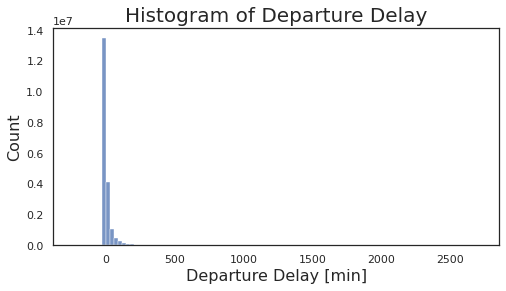

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,4))

ax = sns.histplot(data=df, x='DEP_DELAY', bins=100)
ax.axes.set_title("Histogram of Departure Delay",fontsize=20)
ax.set_xlabel("Departure Delay [min]",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig('DEP_DELAY.png')

plt.show()

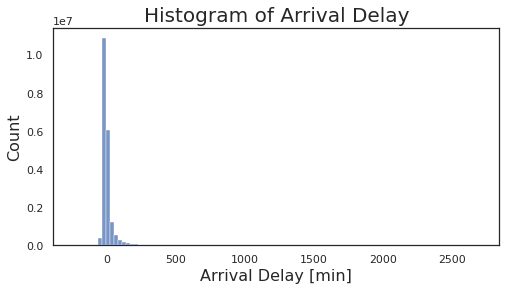

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,4))

ax = sns.histplot(data=df, x='ARR_DELAY', bins=100)
ax.axes.set_title("Histogram of Arrival Delay",fontsize=20)
ax.set_xlabel("Arrival Delay [min]",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig('ARR_DELAY.png')

plt.show()

## Categorical variables

In [ ]:
carrier_vars = ['OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM','OP_CARRIER_FL_NUM']
origin_vars = ['ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','ORIGIN_CITY_MARKET_ID','ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR']
dest_vars = ['DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','DEST_CITY_MARKET_ID','DEST','DEST_CITY_NAME','DEST_STATE_ABR']

In [ ]:
for col in carrier_vars + origin_vars + dest_vars:
    df[col] = df[col].astype('category')

In [ ]:
df[carrier_vars].describe()

,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM
count,19919460,19919460,19919460,19919460,19919460
unique,18,18,18,7200,7167
top,WN,19393,WN,N483HA,511
freq,3968160,3968160,3968160,10210,9907


In [ ]:
df[origin_vars].describe()

,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR
count,19919460,19919460,19919460,19919460,19919460,19919460
unique,364,635,338,364,356,52
top,10397,1039707,31703,ATL,"Chicago, IL",CA
freq,1135900,804128,1193649,1135900,1166071,2327693


In [ ]:
df[dest_vars].describe()

,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR
count,19919460,19919460,19919460,19919460,19919460,19919460
unique,365,636,339,365,357,52
top,10397,1039707,31703,ATL,"Chicago, IL",CA
freq,1135936,804433,1191420,1135936,1164209,2328769


## Weather

In [ ]:
WEATHER_DIR = os.path.join(DIR,'weather')
weather_df = pd.read_csv(os.path.join(WEATHER_DIR, 'weather_selected_2.csv'))

del weather_df['Unnamed: 0']

In [ ]:
weather_df.head()

,Day,Temperature_Max,Temperature_Avg,Temperature_Min,Dew Point_Max,Dew Point_Avg,Dew Point_Min,Humidity_Max,Humidity_Avg,Humidity_Min,Wind Speed_Max,Wind Speed_Avg,Wind Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation,ICAO
0,2016-01-01,63,55.4,49,49,41.2,30,83,63.1,42,25.0,10.3,0.0,29.9,29.8,29.8,1.29,KLAX
1,2016-01-02,62,54.8,46,53,46.7,42,94,86.0,72,22.0,9.7,0.0,29.8,29.8,29.7,0.01,KLAX
2,2016-01-03,66,59.9,56,56,52.4,45,94,85.0,77,23.0,7.1,0.0,30.0,29.9,29.8,0.00,KLAX
3,2016-01-04,59,56.6,53,54,47.2,43,87,74.3,51,14.0,6.6,0.0,30.1,30.1,30.0,0.01,KLAX
4,2016-01-05,57,51.6,47,47,44.4,36,74,56.5,41,7.0,4.3,0.0,30.1,30.0,30.0,0.00,KLAX


In [ ]:
weather_vars1 = ['Temperature_Max','Temperature_Avg','Temperature_Min','Dew Point_Max','Dew Point_Avg','Dew Point_Min']
weather_df[weather_vars1].describe()

,Temperature_Max,Temperature_Avg,Temperature_Min,Dew Point_Max,Dew Point_Avg,Dew Point_Min
count,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000
mean,67.565541,59.664811,52.470195,55.124544,49.543659,43.030870
std,16.663778,15.605854,15.884872,16.719038,16.690359,17.952454
min,-11.000000,-17.300000,-23.000000,-20.000000,-26.100000,-32.000000
25%,59.000000,51.700000,43.000000,46.000000,38.375000,30.000000
50%,70.000000,62.000000,55.000000,57.000000,53.000000,47.000000
75%,79.000000,70.800000,64.000000,66.000000,61.500000,57.000000
max,162.000000,89.100000,81.000000,145.000000,99.000000,96.000000


In [ ]:
weather_vars2 = ['Humidity_Max','Humidity_Avg','Humidity_Min','Wind Speed_Max','Wind Speed_Avg','Wind Speed_Min']
weather_df[weather_vars2].describe()

,Humidity_Max,Humidity_Avg,Humidity_Min,Wind Speed_Max,Wind Speed_Avg,Wind Speed_Min
count,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000
mean,77.915754,62.271594,44.219434,17.731387,11.187394,5.517716
std,23.471971,22.633487,21.481411,6.558099,7.722739,9.695319
min,6.000000,1.700000,0.000000,5.000000,1.800000,0.000000
25%,75.000000,54.100000,32.000000,13.000000,6.500000,0.000000
50%,86.000000,68.400000,47.000000,16.000000,8.300000,0.000000
75%,93.000000,77.800000,60.000000,21.000000,11.900000,6.000000
max,100.000000,99.800000,97.000000,45.000000,30.200000,30.100000


In [ ]:
weather_vars3 = ['Pressure_Max','Pressure_Avg','Pressure_Min','Precipitation']
weather_df[weather_vars3].describe()

,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation
count,6576.000000,5481.000000,5481.000000,5262.000000
mean,24.559293,29.374001,29.267761,0.099285
std,10.946394,0.396735,1.121763,0.324888
min,0.000000,25.600000,0.000000,0.000000
25%,29.000000,29.000000,29.000000,0.000000
50%,29.300000,29.300000,29.200000,0.000000
75%,29.800000,29.800000,29.700000,0.010000
max,30.400000,30.300000,30.200000,4.040000


In [ ]:
weather_df['Day'] = pd.to_datetime(weather_df['Day'])

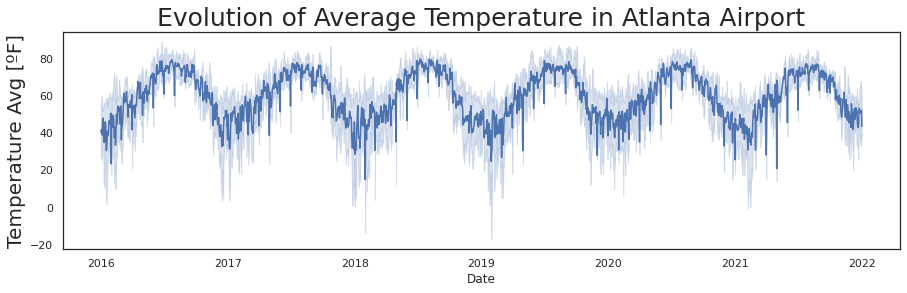

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(15,4))

ax = sns.lineplot(data=weather_df, x='Day', y='Temperature_Avg') 
ax.axes.set_title("Evolution of Average Temperature in Atlanta Airport",fontsize=25)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature Avg [ºF]",fontsize=20)

plt.savefig('weather_temp.png')

plt.show()

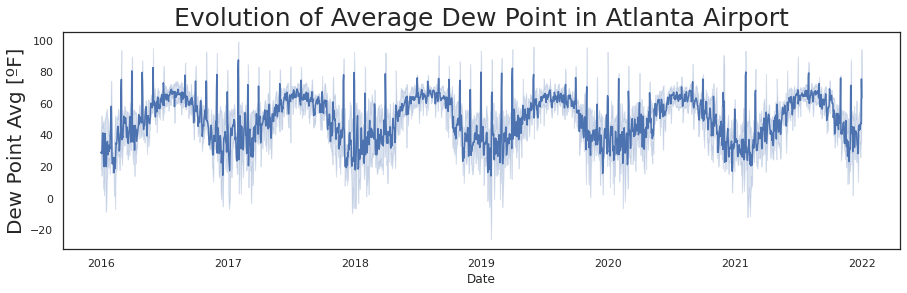

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(15,4))

ax = sns.lineplot(data=weather_df, x='Day', y='Dew Point_Avg') 
ax.axes.set_title("Evolution of Average Dew Point in Atlanta Airport",fontsize=25)
ax.set_xlabel("Date")
ax.set_ylabel("Dew Point Avg [ºF]",fontsize=20)

plt.savefig('weather_dewpoint.png')

plt.show()

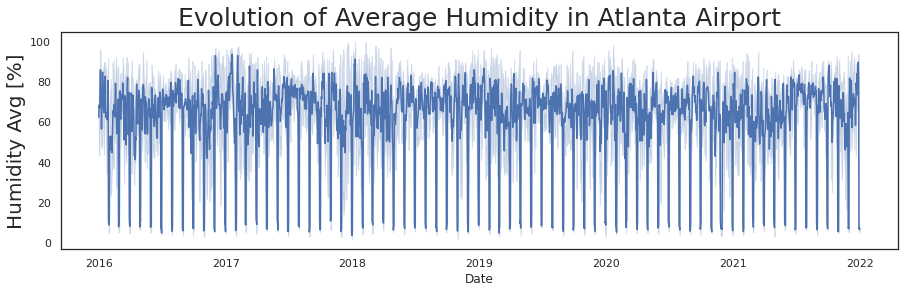

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(15,4))

ax = sns.lineplot(data=weather_df, x='Day', y='Humidity_Avg') 
ax.axes.set_title("Evolution of Average Humidity in Atlanta Airport",fontsize=25)
ax.set_xlabel("Date")
ax.set_ylabel("Humidity Avg [%]",fontsize=20)

plt.savefig('weather_humidity.png')

plt.show()

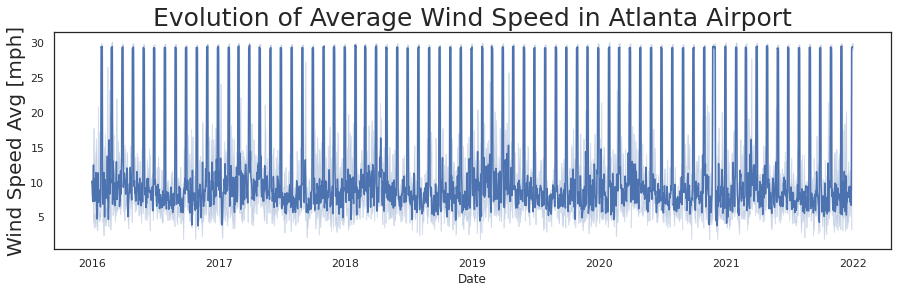

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(15,4))

ax = sns.lineplot(data=weather_df, x='Day', y='Wind Speed_Avg') 
ax.axes.set_title("Evolution of Average Wind Speed in Atlanta Airport",fontsize=25)
ax.set_xlabel("Date")
ax.set_ylabel("Wind Speed Avg [mph]",fontsize=20)

plt.savefig('weather_windspeed.png')

plt.show()

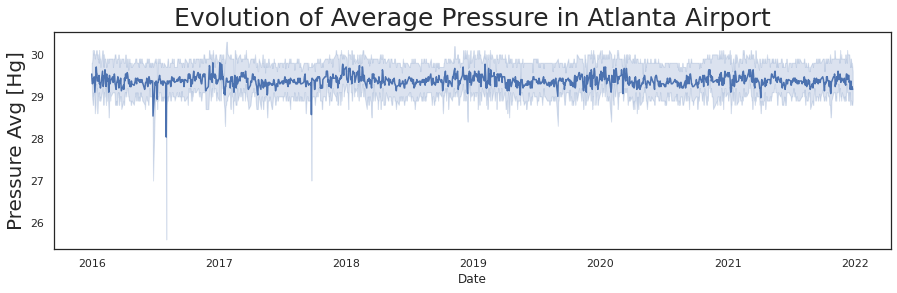

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(15,4))

ax = sns.lineplot(data=weather_df, x='Day', y='Pressure_Avg') 
ax.axes.set_title("Evolution of Average Pressure in Atlanta Airport",fontsize=25)
ax.set_xlabel("Date")
ax.set_ylabel("Pressure Avg [Hg]",fontsize=20)

plt.savefig('weather_pressure.png')

plt.show()

In [ ]:
del weather_df, ax

# Multivariate Analysis

## All Airports

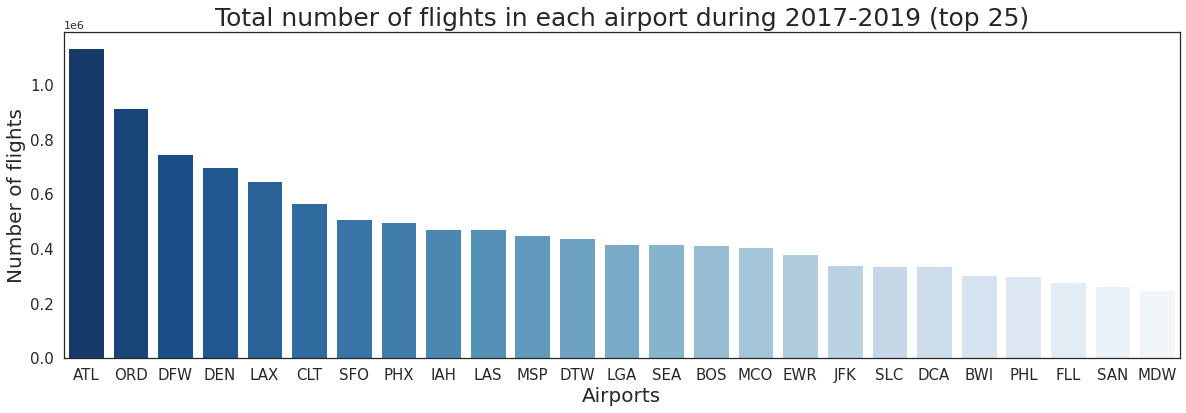

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1}, palette='Blues')
plt.figure(figsize=(20,6))

dest_vc = df['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(25)

ax = sns.barplot(x="index", y="DEST", data=dest_vc, palette = "Blues_r")
ax.axes.set_title("Total number of flights in each airport during 2017-2019 (top 25)",fontsize=25)
ax.set_xlabel("Airports",fontsize=20)
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


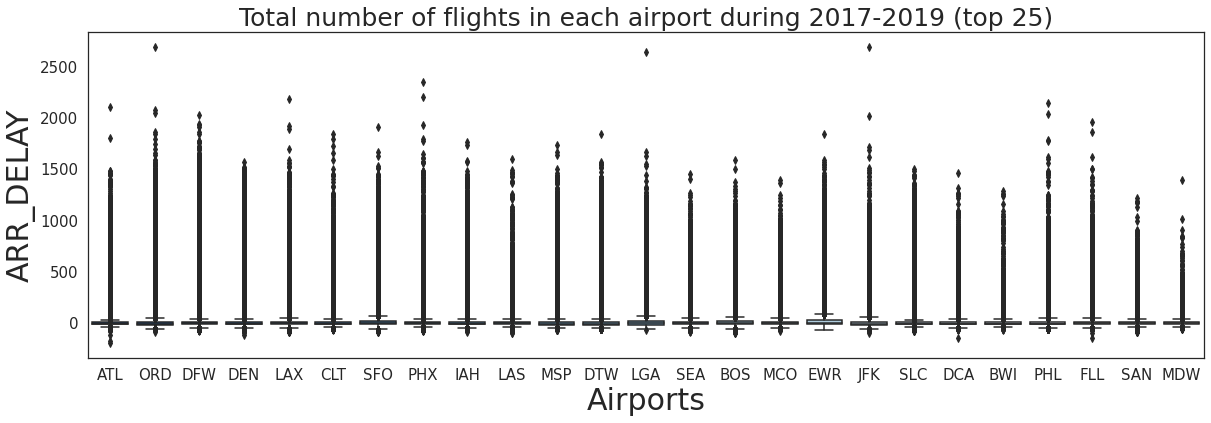

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

dest_map = {k:v for k,v in zip(dest_vc['index'], range(len(dest_vc.index)))}

dest_delay = df[df.DEST.isin(dest_vc['index'].to_list())]
dest_delay['DEST'] = dest_delay['DEST'].astype('string')
dest_delay['idx'] =  dest_delay['DEST'].map(dest_map)
dest_delay = dest_delay.sort_values('idx')

ax2_ = sns.boxplot(x="DEST", y="ARR_DELAY", data=dest_delay, palette = "Blues_r")
ax2_.axes.set_title("Total number of flights in each airport during 2017-2019 (top 25)",fontsize=25)
ax2_.set_xlabel("Airports",fontsize=30)
ax2_.set_ylabel("ARR_DELAY",fontsize=30)
ax2_.tick_params(labelsize=15)

del dest_vc

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


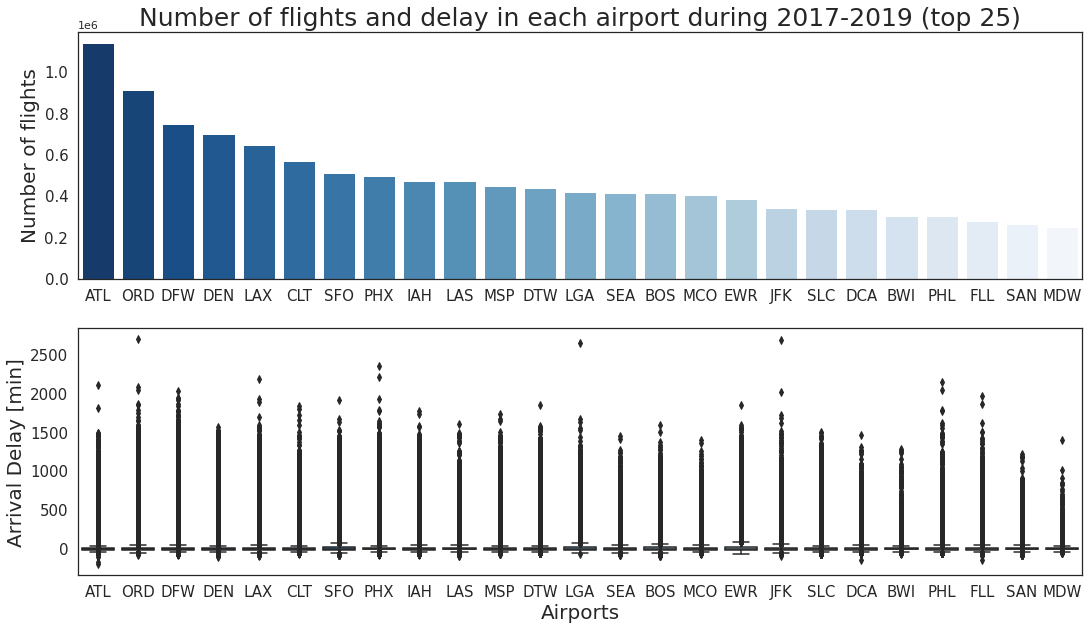

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

dest_vc = df['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(25)

sns.barplot(x="index", y="DEST", data=dest_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Number of flights and delay in each airport during 2017-2019 (top 25)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)

dest_map = {k:v for k,v in zip(dest_vc['index'], range(len(dest_vc.index)))}

dest_delay = df[df.DEST.isin(dest_vc['index'].to_list())]
dest_delay['DEST'] = dest_delay['DEST'].astype('string')
dest_delay['idx'] =  dest_delay['DEST'].map(dest_map)
dest_delay = dest_delay.sort_values('idx')

sns.boxplot(x="DEST", y="ARR_DELAY", data=dest_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airports",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=15)

plt.savefig('all_dest.png')

plt.show()

In [ ]:
del dest_vc, dest_delay, fig, ax1, ax2
gc.collect()

72

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


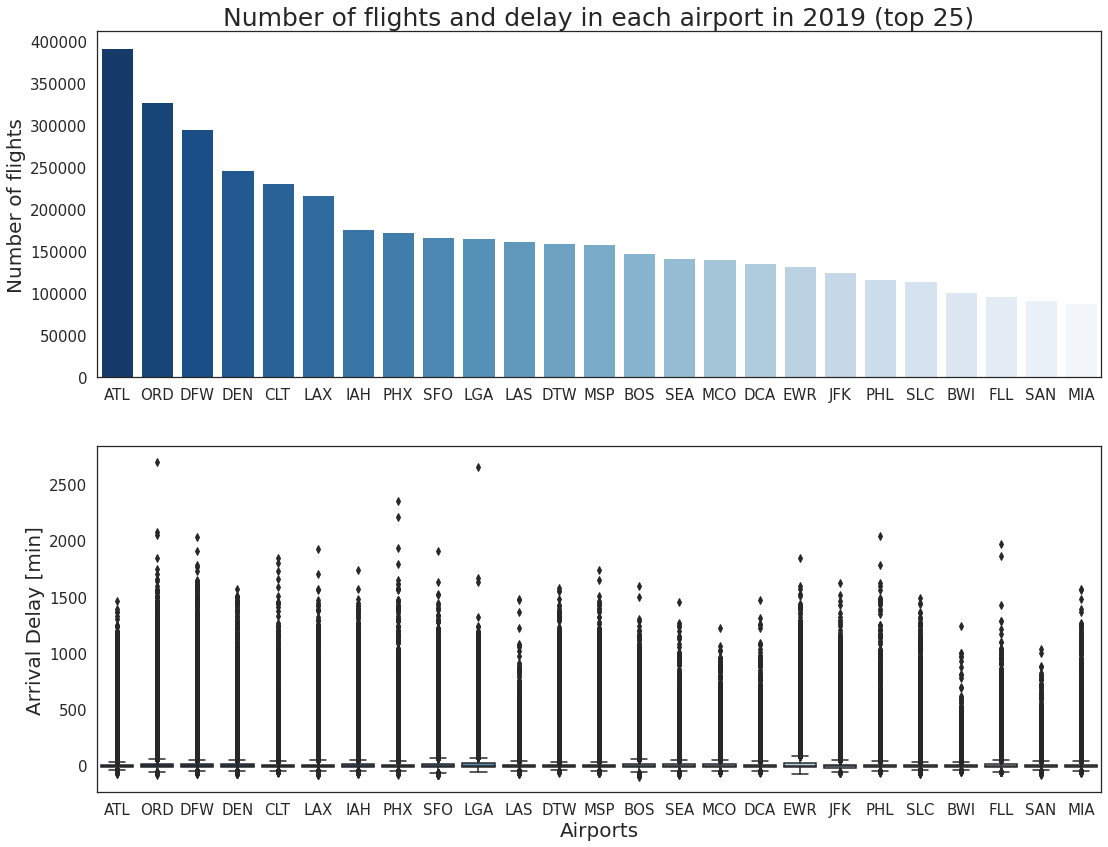

In [ ]:
# figure size in inches
rcParams['figure.figsize'] = 18,14
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

dest_vc = df[df.year == 2019]['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(25)

sns.barplot(x="index", y="DEST", data=dest_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Number of flights and delay in each airport in 2019 (top 25)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)

dest_map = {k:v for k,v in zip(dest_vc['index'], range(len(dest_vc.index)))}

dest_delay = df[df.year == 2019][df.DEST.isin(dest_vc['index'].to_list())]
dest_delay['DEST'] = dest_delay['DEST'].astype('string')
dest_delay['idx'] =  dest_delay['DEST'].map(dest_map)
dest_delay = dest_delay.sort_values('idx')

sns.boxplot(x="DEST", y="ARR_DELAY", data=dest_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airports",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=15)

plt.savefig('all_dest_2019.png')

plt.show()

## Airlines

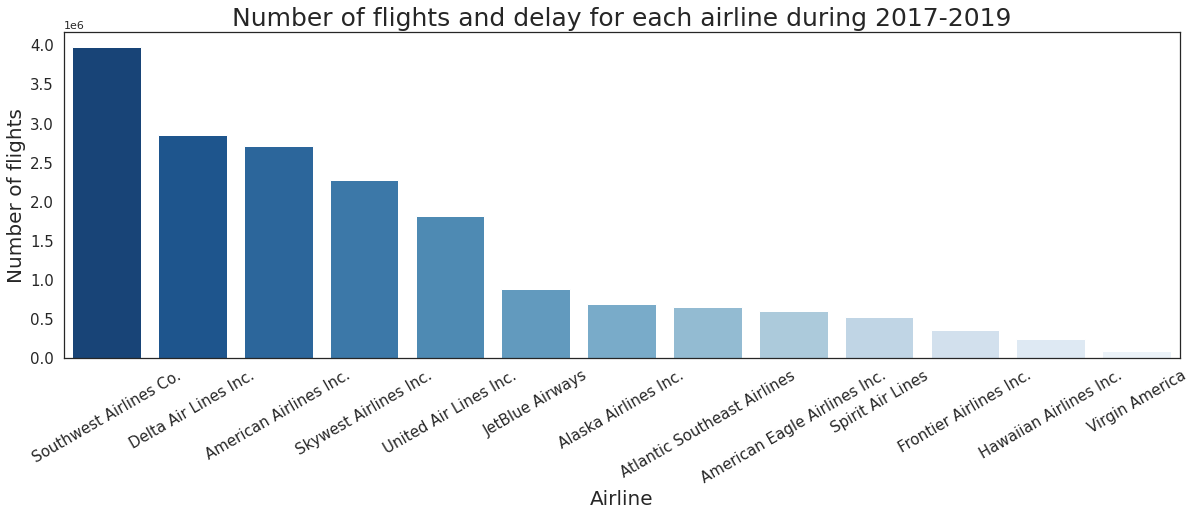

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(20,6))

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

ax = sns.barplot(x="AIRLINE", y="OP_UNIQUE_CARRIER", data=carrier_vc.head(20), palette = "Blues_r")
ax.axes.set_title("Number of flights and delay for each airline during 2017-2019",fontsize=25)
ax.set_xlabel("Airline",fontsize=20)
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

del carrier_vc, airlines

plt.show()

In [ ]:
gc.collect()

28524

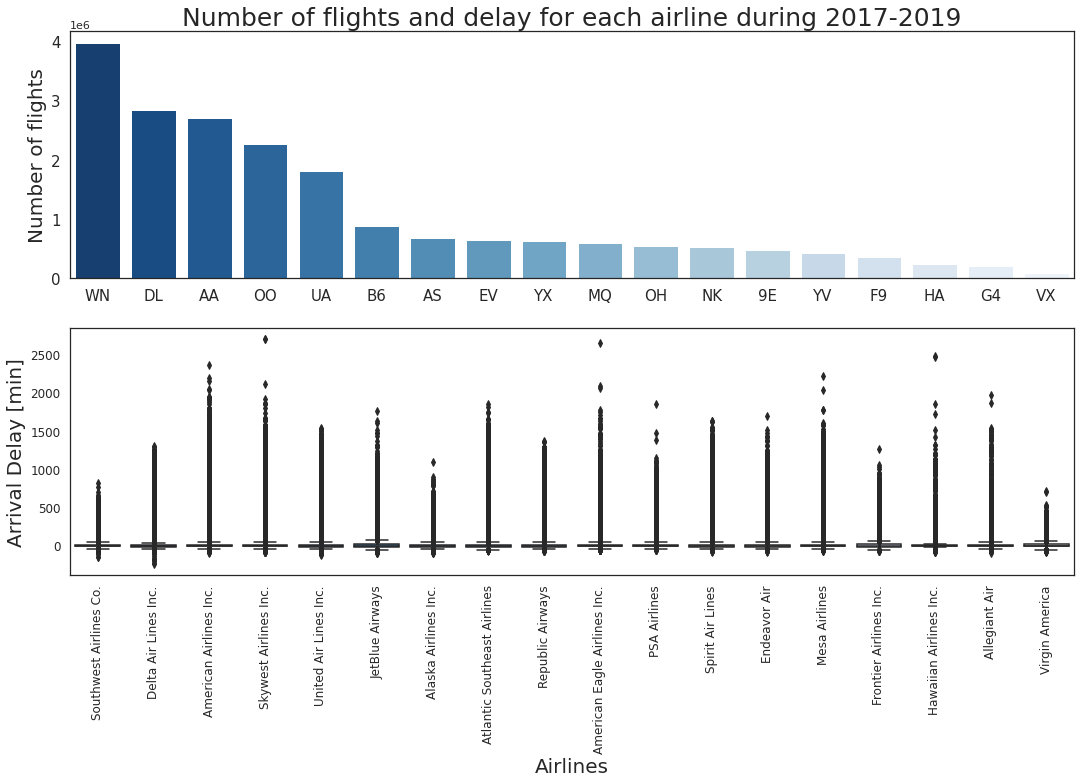

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

fig, (ax1, ax2) = plt.subplots(nrows=2)

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc['index'] = carrier_vc['index'].astype('string')
carrier_vc = carrier_vc.head(30)

carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

sns.barplot(x="index", y="OP_UNIQUE_CARRIER", data=carrier_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Number of flights and delay for each airline during 2017-2019",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)
#ax1.set_xticklabels([])

carrier_order = {k:v for k,v in zip(carrier_vc['index'], range(len(carrier_vc.index)))}
carrier_name = {k:v for k,v in zip(carrier_vc['index'], carrier_vc['AIRLINE'])}

# Fix Carrier names
carrier_name['9E'] = 'Endeavor Air'
carrier_name['G4'] = 'Allegiant Air'
carrier_name['OH'] = 'PSA Airlines'
carrier_name['YV'] = 'Mesa Airlines'
carrier_name['YX'] = 'Republic Airways'

carrier_delay = df[df.OP_UNIQUE_CARRIER.isin(carrier_vc['index'].to_list())]
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')
carrier_delay['AIRLINE'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_name) 
carrier_delay['idx'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_order)

carrier_delay['AIRLINE'] = carrier_delay['AIRLINE'].astype('string')
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')

#carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'AIRLINE'] = carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'OP_UNIQUE_CARRIER']
carrier_delay = carrier_delay.sort_values('idx')

sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=carrier_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airlines",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)

plt.savefig('all_airlines.png')

plt.show()

In [ ]:
del airlines, fig, ax1, ax2, carrier_vc, carrier_order, carrier_name, carrier_delay

In [ ]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)
df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].describe(include = np.number, percentiles = perc).sort_values('count', ascending=False)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
OP_UNIQUE_CARRIER,,,,,,,,,,,,
WN,3968160.0,4.043656,31.629952,-151.0,-22.0,-18.0,-12.0,-4.0,8.0,32.0,58.0,809.0
DL,2844654.0,0.291753,45.100935,-238.0,-28.0,-24.0,-16.0,-9.0,2.0,24.0,54.0,1304.0
AA,2705987.0,5.440244,48.618508,-94.0,-27.0,-22.0,-14.0,-5.0,9.0,38.0,73.0,2350.0
OO,2270649.0,7.106454,61.722031,-91.0,-27.0,-22.0,-15.0,-7.0,7.0,42.0,86.0,2696.0
UA,1810834.0,5.343592,51.780065,-120.0,-28.0,-23.0,-16.0,-7.0,7.0,42.0,83.0,1539.0
B6,880109.0,11.213161,55.018777,-99.0,-30.0,-25.0,-16.0,-5.0,17.0,65.0,112.0,1756.0
AS,687050.0,0.504062,32.755632,-106.0,-30.0,-25.0,-16.0,-6.0,7.0,28.0,52.0,1087.0
EV,653337.0,9.727458,66.550641,-69.0,-27.0,-23.0,-16.0,-7.0,10.0,53.0,102.0,1844.0
YX,625867.0,3.893808,46.865331,-77.0,-28.0,-24.0,-17.0,-8.0,7.0,40.0,78.0,1360.0


In [ ]:
gc.collect()

38906

In [ ]:
df = df[(df.DEP_DELAY.isnull() == False) & (df.ARR_DELAY.isnull() == False)]
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)

# Atlanta Airport
## Arrivals and Departures

In [ ]:
df = df[(df.DEST_AIRPORT_ID == AIRPORT) | (df.ORIGIN_AIRPORT_ID == AIRPORT)]

In [ ]:
df.loc[(df.ORIGIN_AIRPORT_ID == AIRPORT), 'FLIGHT'] = 'DEPARTURE'
df.loc[(df.DEST_AIRPORT_ID == AIRPORT), 'FLIGHT'] = 'ARRIVAL'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)


In [ ]:
df['FLIGHT'].value_counts()

ARRIVAL      1135936
DEPARTURE    1135900
Name: FLIGHT, dtype: int64

In [ ]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
df['ARR_DELAY'] = df['ARR_DELAY'].astype(int)
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)

df.loc[df.FLIGHT == 'ARRIVAL', 'ARR_DELAY'].describe(include = np.number, percentiles = perc).astype('float16')

count            inf
mean        1.914062
std        47.593750
min      -202.000000
5%        -26.000000
10%       -22.000000
25%       -16.000000
50%        -8.000000
75%         3.000000
90%        26.000000
95%        58.000000
max      2108.000000
Name: ARR_DELAY, dtype: float16

In [ ]:
df.loc[df.FLIGHT == 'DEPARTURE', 'DEP_DELAY'].describe(include = np.number, percentiles = perc).astype('float16')

count            inf
mean        9.453125
std        39.343750
min      -234.000000
5%         -7.000000
10%        -6.000000
25%        -4.000000
50%        -1.000000
75%         6.000000
90%        31.000000
95%        60.000000
max      1587.000000
Name: DEP_DELAY, dtype: float16

In [ ]:
from scipy import stats
stats.pearsonr(df['DEP_DELAY'], df['ARR_DELAY'])

(0.9611687669170055, 0.0)

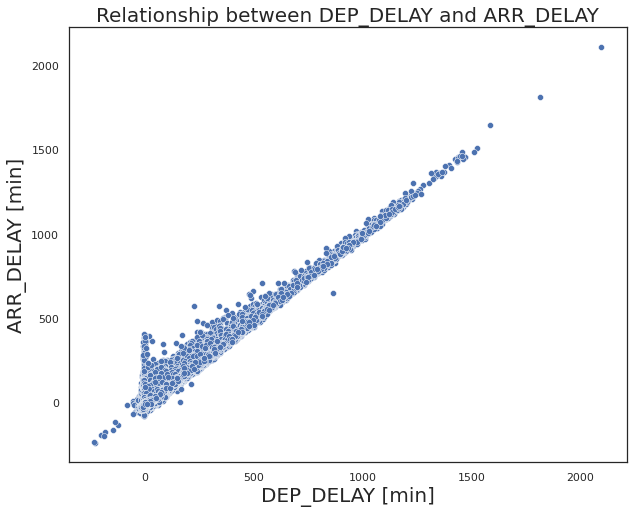

In [ ]:
rcParams['figure.figsize'] = 10,8
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=df)
ax.set_title("Relationship between DEP_DELAY and ARR_DELAY", fontsize=20)
ax.set_xlabel("DEP_DELAY [min]",fontsize=20)
ax.set_ylabel("ARR_DELAY [min]",fontsize=20)

plt.savefig('dep_vs_arr.png')

plt.show()

## Airlines

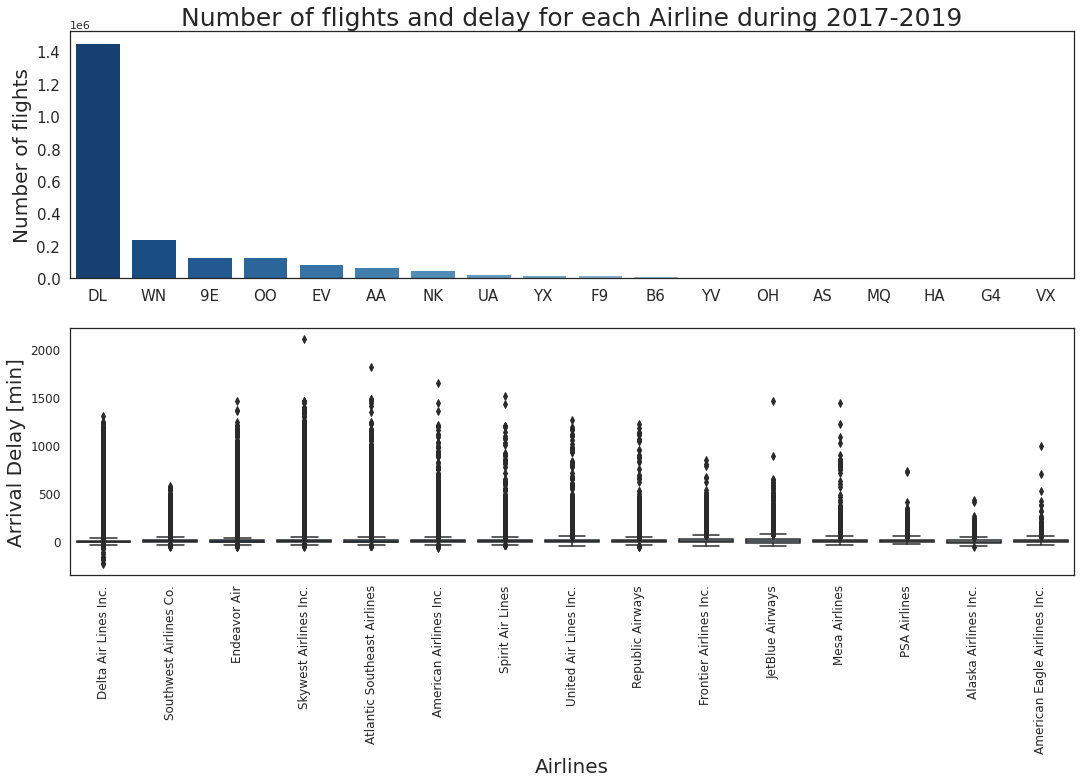

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

fig, (ax1, ax2) = plt.subplots(nrows=2)

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc['index'] = carrier_vc['index'].astype('string')
carrier_vc = carrier_vc.head(30)

carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

sns.barplot(x="index", y="OP_UNIQUE_CARRIER", data=carrier_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Number of flights and delay for each Airline during 2017-2019",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)
#ax1.set_xticklabels([])

carrier_order = {k:v for k,v in zip(carrier_vc['index'], range(len(carrier_vc.index)))}
carrier_name = {k:v for k,v in zip(carrier_vc['index'], carrier_vc['AIRLINE'])}

# Fix Carrier names
carrier_name['9E'] = 'Endeavor Air'
carrier_name['G4'] = 'Allegiant Air'
carrier_name['OH'] = 'PSA Airlines'
carrier_name['YV'] = 'Mesa Airlines'
carrier_name['YX'] = 'Republic Airways'

carrier_delay = df[df.OP_UNIQUE_CARRIER.isin(carrier_vc['index'].to_list())]
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')
carrier_delay['AIRLINE'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_name) 
carrier_delay['idx'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_order)

carrier_delay['AIRLINE'] = carrier_delay['AIRLINE'].astype('string')
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')

#carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'AIRLINE'] = carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'OP_UNIQUE_CARRIER']
carrier_delay = carrier_delay.sort_values('idx')

sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=carrier_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airlines",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)

plt.savefig('all_airlines_atl.png')

plt.show()

In [ ]:
carrier_vc_ = carrier_vc[['index','AIRLINE','OP_UNIQUE_CARRIER']]
carrier_vc_.columns = ['IATA code', 'Airline', 'Number of arrivals']
carrier_vc_

,IATA code,Airline,Number of arrivals
0,DL,Delta Air Lines Inc.,1451320
1,WN,Southwest Airlines Co.,243013
2,9E,NaN,132313
3,OO,Skywest Airlines Inc.,130156
4,EV,Atlantic Southeast Airlines,90414
5,AA,American Airlines Inc.,71422
6,NK,Spirit Air Lines,48794
7,UA,United Air Lines Inc.,27321
8,YX,NaN,21465
9,F9,Frontier Airlines Inc.,20766


## Time of the day

In [ ]:
df['ARR_TIME_'] = df['ARR_TIME'].apply(lambda x: math.trunc(x)/100).astype(int)
df['DEP_TIME_'] = df['DEP_TIME'].apply(lambda x: math.trunc(x)/100).astype(int)

df.loc[df.DEP_TIME_ == 24, 'DEP_TIME_'] = 0
df.loc[df.ARR_TIME_ == 24, 'ARR_TIME_'] = 0

In [ ]:
dep_delay = df.loc[df.FLIGHT == 'DEPARTURE', ['FL_DATE','DEP_TIME_','DEP_DELAY']]
arr_delay = df.loc[df.FLIGHT == 'ARRIVAL', ['FL_DATE','ARR_TIME_','ARR_DELAY']]

arr_delay = arr_delay.groupby(['ARR_TIME_'])['ARR_DELAY'].describe().reset_index()
arr_delay.columns = arr_delay.columns + '_ARR'
arr_delay.rename(columns={"ARR_TIME__ARR": "TIME"}, inplace=True)

dep_delay = dep_delay.groupby(['DEP_TIME_'])['DEP_DELAY'].describe().reset_index()
dep_delay.columns = dep_delay.columns + '_DEP'
dep_delay.rename(columns={"DEP_TIME__DEP": "TIME"}, inplace=True)

arr_dep_delay = pd.merge(arr_delay, dep_delay, on=['TIME'], how='outer')
arr_dep_delay.head(20)

,TIME,count_ARR,mean_ARR,std_ARR,min_ARR,25%_ARR,50%_ARR,75%_ARR,max_ARR,count_DEP,mean_DEP,std_DEP,min_DEP,25%_DEP,50%_DEP,75%_DEP,max_DEP
0,0,9107.0,60.365104,107.288524,-39.0,-5.0,18.0,87.00,1006.0,4094.0,116.057890,81.882618,-6.0,57.0,103.0,150.0,757.0
1,1,2812.0,145.545875,152.643234,-35.0,43.0,102.5,211.00,2108.0,1271.0,190.342250,79.227124,-4.0,138.0,177.0,225.0,667.0
2,2,966.0,233.302277,157.708506,-25.0,131.0,195.0,300.00,1093.0,476.0,258.250000,98.192971,-6.0,202.0,239.0,288.0,1225.0
3,3,404.0,306.000000,186.443067,-43.0,198.0,270.0,369.25,1169.0,159.0,309.962264,77.876231,194.0,265.5,291.0,339.5,659.0
4,4,1609.0,12.426973,119.504657,-65.0,-24.0,-16.0,-8.00,1150.0,161.0,102.229814,182.881733,-11.0,-8.0,-6.0,284.0,792.0
5,5,6135.0,-4.397229,45.444802,-53.0,-17.0,-10.0,-1.00,1013.0,7935.0,4.981348,69.817403,-234.0,-6.0,-4.0,-2.0,1144.0
6,6,19810.0,-7.567037,23.222703,-79.0,-16.0,-10.0,-3.00,1155.0,19801.0,4.996768,61.696882,-201.0,-5.0,-3.0,0.0,1161.0
7,7,67276.0,-8.729740,17.133954,-63.0,-16.0,-10.0,-4.00,1140.0,34054.0,3.864216,53.111776,-20.0,-4.0,-2.0,0.0,1158.0
8,8,90343.0,-8.053009,23.610587,-62.0,-16.0,-10.0,-3.00,1366.0,85447.0,1.091367,34.245808,-32.0,-4.0,-2.0,0.0,1223.0
9,9,82970.0,-2.620477,34.543885,-49.0,-14.0,-8.0,2.00,1409.0,80555.0,2.720067,30.255824,-55.0,-4.0,-2.0,1.0,1435.0


In [ ]:
arr_delay = df.loc[df.FLIGHT == 'ARRIVAL', ['FL_DATE','ARR_TIME_','ARR_DELAY']]
arr_delay = arr_delay.groupby(['ARR_TIME_'])['ARR_DELAY'].describe().reset_index()
arr_delay.rename(columns={"ARR_TIME_": "TIME"}, inplace=True)
arr_delay

,TIME,count,mean,std,min,25%,50%,75%,max
0,0,9107.0,60.365104,107.288524,-39.0,-5.0,18.0,87.00,1006.0
1,1,2812.0,145.545875,152.643234,-35.0,43.0,102.5,211.00,2108.0
2,2,966.0,233.302277,157.708506,-25.0,131.0,195.0,300.00,1093.0
3,3,404.0,306.000000,186.443067,-43.0,198.0,270.0,369.25,1169.0
4,4,1609.0,12.426973,119.504657,-65.0,-24.0,-16.0,-8.00,1150.0
5,5,6135.0,-4.397229,45.444802,-53.0,-17.0,-10.0,-1.00,1013.0
6,6,19810.0,-7.567037,23.222703,-79.0,-16.0,-10.0,-3.00,1155.0
7,7,67276.0,-8.729740,17.133954,-63.0,-16.0,-10.0,-4.00,1140.0
8,8,90343.0,-8.053009,23.610587,-62.0,-16.0,-10.0,-3.00,1366.0
9,9,82970.0,-2.620477,34.543885,-49.0,-14.0,-8.0,2.00,1409.0


In [ ]:
dep_delay = df.loc[df.FLIGHT == 'DEPARTURE', ['FL_DATE','DEP_TIME_','DEP_DELAY']]
dep_delay = dep_delay.groupby(['DEP_TIME_'])['DEP_DELAY'].describe().reset_index()
dep_delay.rename(columns={"DEP_TIME_": "TIME"}, inplace=True)
dep_delay

,TIME,count,mean,std,min,25%,50%,75%,max
0,0,4094.0,116.057890,81.882618,-6.0,57.0,103.0,150.0,757.0
1,1,1271.0,190.342250,79.227124,-4.0,138.0,177.0,225.0,667.0
2,2,476.0,258.250000,98.192971,-6.0,202.0,239.0,288.0,1225.0
3,3,159.0,309.962264,77.876231,194.0,265.5,291.0,339.5,659.0
4,4,161.0,102.229814,182.881733,-11.0,-8.0,-6.0,284.0,792.0
5,5,7935.0,4.981348,69.817403,-234.0,-6.0,-4.0,-2.0,1144.0
6,6,19801.0,4.996768,61.696882,-201.0,-5.0,-3.0,0.0,1161.0
7,7,34054.0,3.864216,53.111776,-20.0,-4.0,-2.0,0.0,1158.0
8,8,85447.0,1.091367,34.245808,-32.0,-4.0,-2.0,0.0,1223.0
9,9,80555.0,2.720067,30.255824,-55.0,-4.0,-2.0,1.0,1435.0


In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'DEPARTURE'], x='DEP_TIME_', ax=ax1)
ax1.axes.set_title("Number of departure flights and delay for each hour",fontsize=25)
ax1.set_xlabel("Departure Hour",fontsize=20)
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)

sns.boxplot(data=df.loc[(df.FLIGHT == 'DEPARTURE')], x='DEP_TIME_', y='DEP_DELAY', ax=ax2)
ax2.set_xlabel("Departure Hour",fontsize=20)
ax2.set_ylabel("Departure Delay [min]",fontsize=20)
ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)

plt.savefig('dep_hour.png')

plt.show()

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'ARRIVAL'], x='ARR_TIME_', ax=ax1)
ax1.axes.set_title("Number of arrival flights and delay for each hour",fontsize=25)
ax1.set_xlabel("Arrival Hour",fontsize=20)
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)

sns.boxplot(data=df.loc[(df.FLIGHT == 'ARRIVAL')], x='ARR_TIME_', y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Departure Hour",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)

plt.savefig('arr_hour.png')

plt.show()

# Atlanta airport arrivals

In [ ]:
df.shape

In [ ]:
df = df[(df.DEST_AIRPORT_ID == AIRPORT)]

In [ ]:
df.shape

## Delay

In [ ]:
df['DELAY_type'] = '1- Early (15 min or more before)'
df.loc[(df.ARR_DELAY >= -15), 'DELAY_type'] = '2- On time (Between 15 min before and 15 min late)'
df.loc[(df.ARR_DELAY >= 15), 'DELAY_type'] = '3- Late (Between 30 min and 60 min late)'
df.loc[(df.ARR_DELAY >= 60), 'DELAY_type'] = '4- Late (Between 60 min and 120 min late)'
df.loc[(df.ARR_DELAY >= 120), 'DELAY_type'] = '5- Late (Between 120 min and 300 min late)'
df.loc[(df.ARR_DELAY >= 300), 'DELAY_type'] = '6- Late (More than 300 min late)'

df['DELAY_type'].value_counts(normalize=True)*100

# Outliers

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

ax = sns.histplot(data=df, x='ARR_DELAY', bins=100)
ax.axes.set_title("Histogram of Arrival Delay (with outliers)",fontsize=20)
ax.set_xlabel("ARR_DELAY",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig('ARR_DELAY_with.png')
plt.show()

In [ ]:
perc =[0.005, 0.01, 0.02, 0.05, .10, .25, 0.5, 0.75, .90, 0.95, 0.97, 0.99, 0.995]
df['ARR_DELAY'].describe(percentiles=perc).astype(int)

In [ ]:
print(df.shape)
print(df.loc[(df.ARR_DELAY >= -35) & (df.ARR_DELAY <= 150)].shape)

if True:
    # DROP OUTLIERS
    df = df.loc[(df.ARR_DELAY >= -35) & (df.ARR_DELAY <= 150)]
else:
    # CLIP OUTLIERS
    df['ARR_DELAY'] = np.clip(df.ARR_DELAY, -35, 150)

In [ ]:
1110432/1135936*100

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

ax = sns.histplot(data=df, x='ARR_DELAY', bins=100)
ax.axes.set_title("Histogram of Arrival Delay (without outliers)",fontsize=20)
ax.set_xlabel("ARR_DELAY",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig('ARR_DELAY_wout.png')
plt.show()

In [ ]:
df[['ARR_DELAY']].agg(['mean','std'])

## Difference between arrival and departure delay

In [ ]:
df['DELAY_DIFF'] = df['ARR_DELAY'] - df['DEP_DELAY']
df[['DELAY_DIFF']].agg(['mean','std'])

In [ ]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

ax = sns.histplot(data=df, x='DELAY_DIFF', bins=100)
ax.axes.set_title("Histogram of Difference between arrival and departure delay",fontsize=20)
ax.set_xlabel("Arrival - Departure Delay [min]",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig('DELAY_DIFF.png')
plt.show()

In [ ]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
df['DELAY_DIFF'].describe(percentiles = perc).astype('float16')

## Origin

In [ ]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
g = df.groupby('ORIGIN')['ARR_DELAY'].describe(include = np.number, percentiles = perc)
g.sort_values('count', ascending=False).head(20)

In [ ]:
g = df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].describe(include = np.number, percentiles = perc)
g.sort_values('count', ascending=False).head(20)

In [ ]:
origin_vc = df['ORIGIN'].value_counts().to_frame()
origin_vc.shape

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

origin_vc = df['ORIGIN'].value_counts().to_frame()
origin_vc = origin_vc.sort_values('ORIGIN',ascending=False)
origin_vc.reset_index(inplace=True)
origin_vc['index'] = origin_vc['index'].astype('string')
origin_vc = origin_vc.head(20)

sns.barplot(x="index", y="ORIGIN", data=origin_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Total number of flights for each origin airport in Atlanta (top 20)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)

origin_map = {k:v for k,v in zip(origin_vc['index'], range(len(origin_vc.index)))}

origin_delay = df[df.ORIGIN.isin(origin_vc['index'].to_list())]
origin_delay['ORIGIN'] = origin_delay['ORIGIN'].astype('string')
origin_delay['idx'] =  origin_delay['ORIGIN'].map(origin_map)
origin_delay = origin_delay.sort_values('idx')

sns.boxplot(x="ORIGIN", y="ARR_DELAY", data=origin_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airports",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=15)

plt.savefig('atl_origin.png')

plt.show()

In [ ]:
state_vc = df['ORIGIN_STATE_ABR'].value_counts().to_frame()
state_vc.shape

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

origin_vc = df['ORIGIN_STATE_ABR'].value_counts().to_frame()
origin_vc = origin_vc.sort_values('ORIGIN_STATE_ABR',ascending=False)
origin_vc.reset_index(inplace=True)
origin_vc['index'] = origin_vc['index'].astype('string')
origin_vc = origin_vc.head(25)

sns.barplot(x="index", y="ORIGIN_STATE_ABR", data=origin_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Total number of flights for each origin state in Atlanta (top 25)",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=30)
ax1.tick_params(labelsize=15)

origin_map = {k:v for k,v in zip(origin_vc['index'], range(len(origin_vc.index)))}

origin_delay = df[df.ORIGIN_STATE_ABR.isin(origin_vc['index'].to_list())]
origin_delay['ORIGIN_STATE_ABR'] = origin_delay['ORIGIN_STATE_ABR'].astype('string')
origin_delay['idx'] =  origin_delay['ORIGIN_STATE_ABR'].map(origin_map)
origin_delay = origin_delay.sort_values('idx')

sns.boxplot(x="ORIGIN_STATE_ABR", y="ARR_DELAY", data=origin_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airports",fontsize=30)
ax2.set_ylabel("ARR_DELAY",fontsize=15)
ax2.tick_params(labelsize=15)

plt.savefig('atl_origin_state.png')

plt.show()

## Carrier

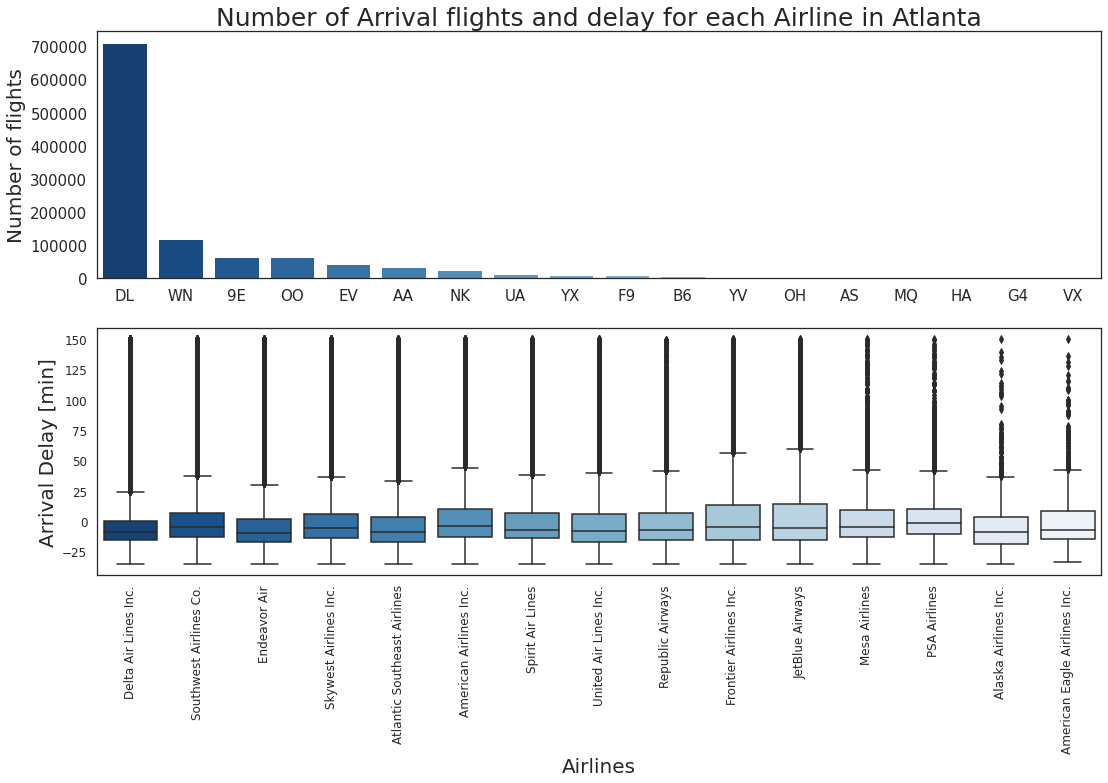

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

airlines = pd.read_csv(os.path.join(DIR, 'airlines_airports', 'airlines.csv'))

fig, (ax1, ax2) = plt.subplots(nrows=2)

carrier_vc = df['OP_UNIQUE_CARRIER'].value_counts().to_frame()
carrier_vc = carrier_vc.sort_values('OP_UNIQUE_CARRIER',ascending=False)
carrier_vc.reset_index(inplace=True)
carrier_vc['index'] = carrier_vc['index'].astype('string')
carrier_vc = carrier_vc.head(30)

carrier_vc = pd.merge(carrier_vc, airlines, how='left', left_on='index', right_on='IATA_CODE')

sns.barplot(x="index", y="OP_UNIQUE_CARRIER", data=carrier_vc, ax=ax1, palette = "Blues_r")
ax1.axes.set_title("Number of Arrival flights and delay for each Airline in Atlanta",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.tick_params(labelsize=15)
#ax1.set_xticklabels([])

carrier_order = {k:v for k,v in zip(carrier_vc['index'], range(len(carrier_vc.index)))}
carrier_name = {k:v for k,v in zip(carrier_vc['index'], carrier_vc['AIRLINE'])}

# Fix Carrier names
carrier_name['9E'] = 'Endeavor Air'
carrier_name['G4'] = 'Allegiant Air'
carrier_name['OH'] = 'PSA Airlines'
carrier_name['YV'] = 'Mesa Airlines'
carrier_name['YX'] = 'Republic Airways'

carrier_delay = df[df.OP_UNIQUE_CARRIER.isin(carrier_vc['index'].to_list())]
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')
carrier_delay['AIRLINE'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_name) 
carrier_delay['idx'] = carrier_delay['OP_UNIQUE_CARRIER'].map(carrier_order)

carrier_delay['AIRLINE'] = carrier_delay['AIRLINE'].astype('string')
carrier_delay['OP_UNIQUE_CARRIER'] = carrier_delay['OP_UNIQUE_CARRIER'].astype('string')

#carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'AIRLINE'] = carrier_delay.loc[carrier_delay.AIRLINE.isnull(), 'OP_UNIQUE_CARRIER']
carrier_delay = carrier_delay.sort_values('idx')

sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=carrier_delay, ax=ax2, palette = "Blues_r")
ax2.set_xlabel("Airlines",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)

plt.savefig('all_airlines_atl.png')

plt.show()

## Weekday

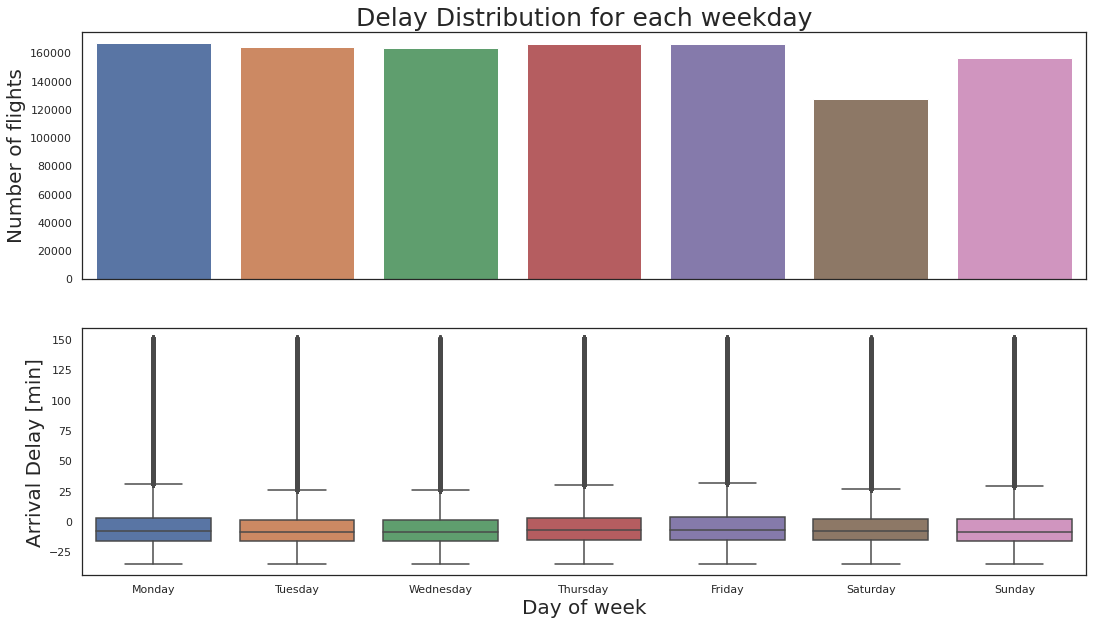

In [ ]:
# figure size in inches
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df.loc[df.FLIGHT == 'ARRIVAL'], x='weekday', ax=ax1)
ax1.axes.set_title("Delay Distribution for each weekday",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.set_xticklabels([])

sns.boxplot(data=df, x="weekday", y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Day of week",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
ax2.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.savefig('weekday.png')

plt.show()

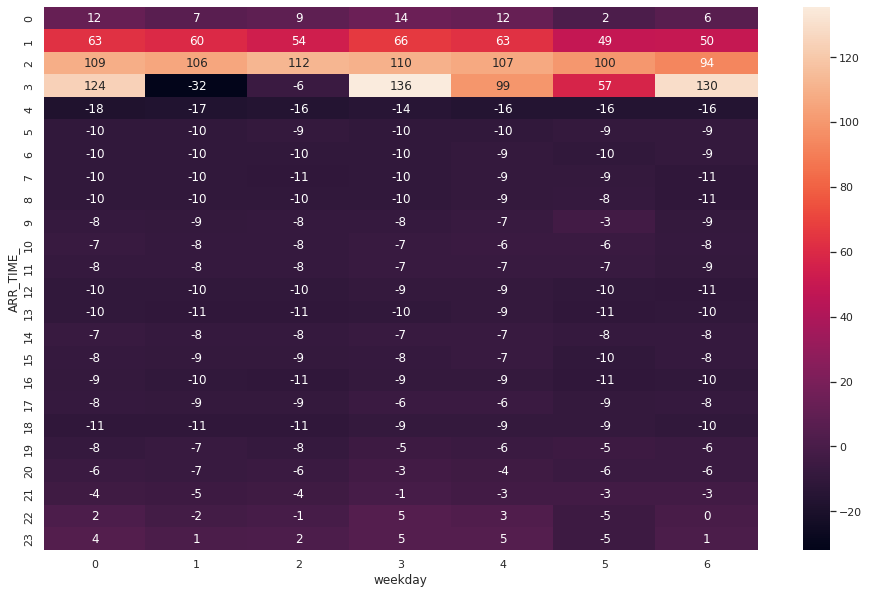

In [ ]:
plt.figure(figsize=(16,10))
pt = pd.pivot_table(df, values='ARR_DELAY', index='ARR_TIME_', columns='weekday', aggfunc='median')
sns.heatmap(pt, annot=True, fmt='.0f')
plt.show()

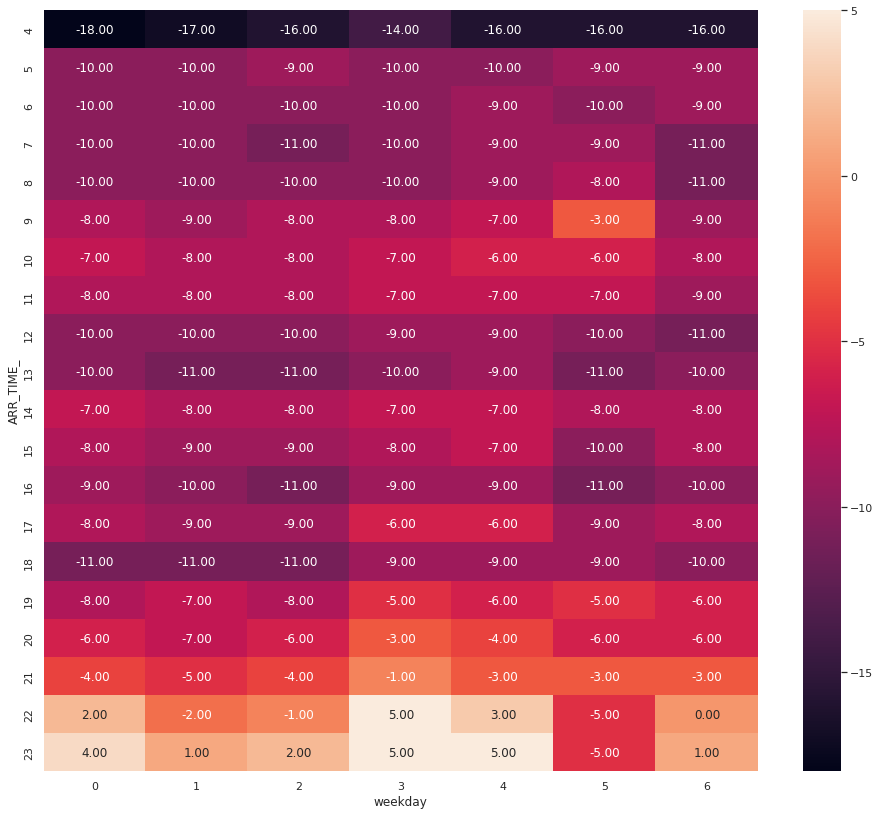

In [ ]:
plt.figure(figsize=(16,14))
pt = pd.pivot_table(df.loc[df.ARR_TIME_ >= 4], values='ARR_DELAY', index='ARR_TIME_', columns='weekday', aggfunc='median')
sns.heatmap(pt, annot=True, fmt='.2f')
plt.show()

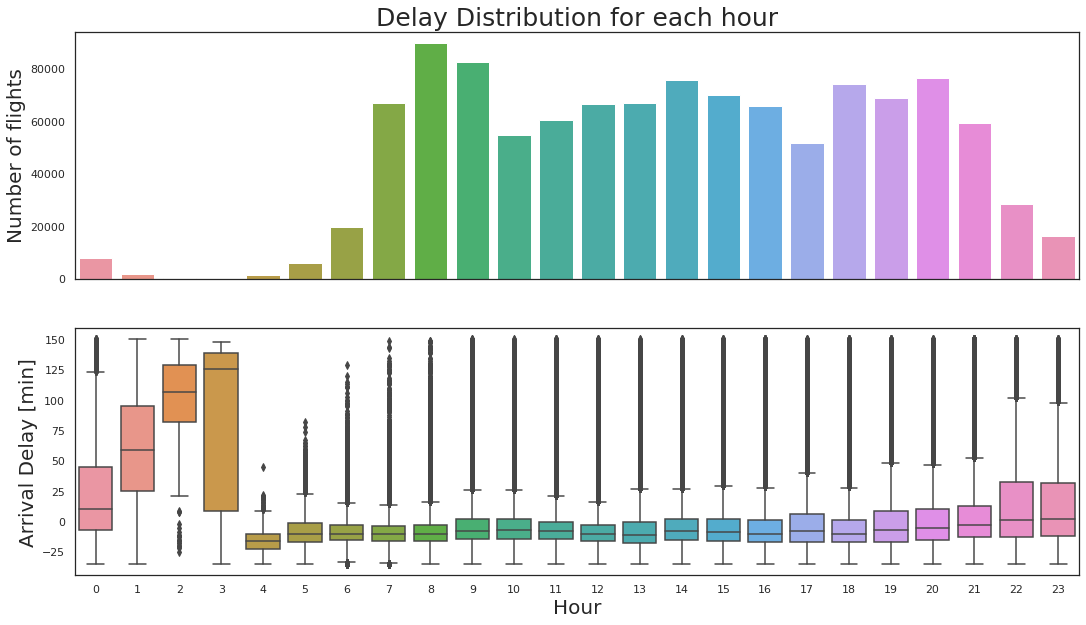

In [ ]:
rcParams['figure.figsize'] = 18,10
sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

df['ARR_TIME_'] = df['ARR_TIME_'].astype(int)
sns.countplot(data=df, x='ARR_TIME_', ax=ax1)
ax1.axes.set_title("Delay Distribution for each hour",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)
ax1.set_xticklabels([])

sns.boxplot(data=df, x='ARR_TIME_', y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Hour",fontsize=20)
ax2.set_ylabel("Arrival Delay [min]",fontsize=20)
#ax2.set_xticklabels(ax2.set_xticklabels, fontsize=20)

plt.savefig('hour.png')

plt.show()

## Month

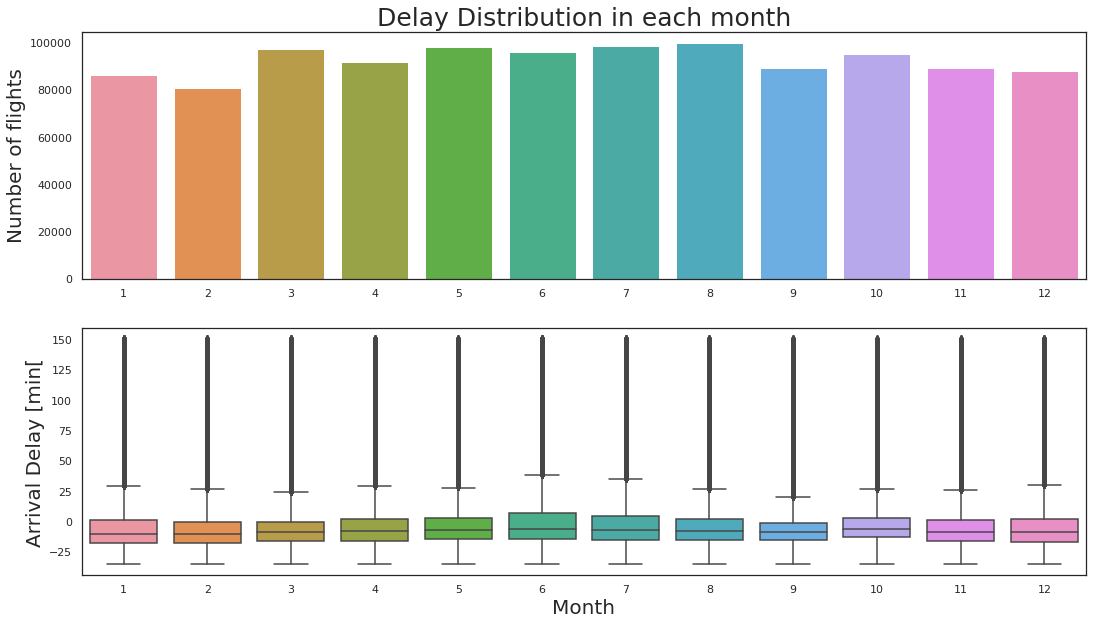

In [ ]:
rcParams['figure.figsize'] = 18,10

sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.countplot(data=df, x='month', ax=ax1)
ax1.axes.set_title("Delay Distribution in each month",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of flights",fontsize=20)

sns.boxplot(data=df, x='month', y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Month",fontsize=20)
ax2.set_ylabel("Arrival Delay [min[",fontsize=20)

plt.savefig('month.png')

plt.show()

## Number of flights in a day

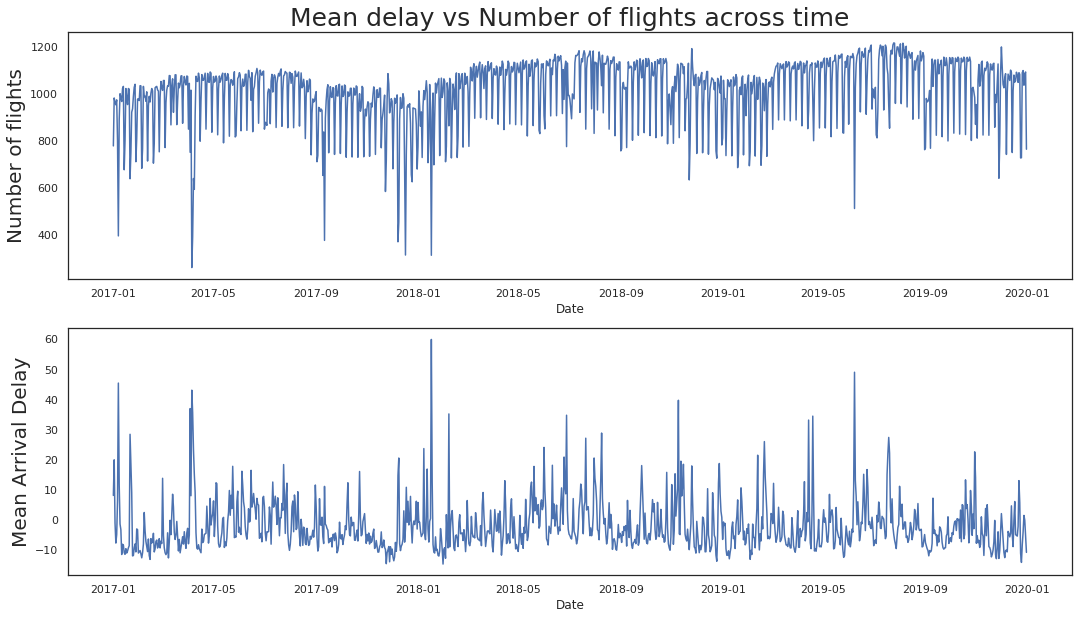

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].count().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax1) 
ax1.axes.set_title("Mean delay vs Number of flights across time",fontsize=25)
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of flights",fontsize=20)

sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].mean().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Date")
ax2.set_ylabel("Mean Arrival Delay",fontsize=20)

plt.savefig('nb_flights.png')

plt.show()

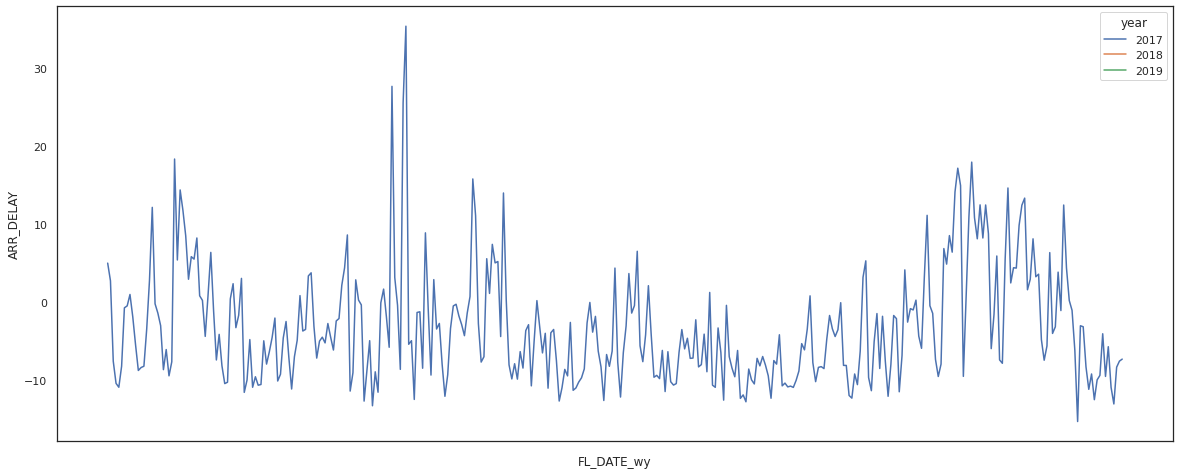

In [ ]:
rcParams['figure.figsize'] = 20,8

sns.set(style='white', rc={"grid.linewidth": 0.1})

fig, ax = plt.subplots()

df['year'] = df['year'].astype('category')
df['FL_DATE_wy'] = df['FL_DATE'].dt.strftime('%m%d')
ax = sns.lineplot(data=df[(df.ARR_DELAY > -200) & (df.ARR_DELAY < 500)].groupby(['FL_DATE_wy','year'])[['ARR_DELAY']].mean().reset_index(), x='FL_DATE_wy', y='ARR_DELAY', hue='year') 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 15)

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df['FL_DATE_hour'] = df['FL_DATE'].astype(str) + '_' + df['ARR_TIME_'].astype(str)

df['FL_DATE_le'] = le.fit_transform(df['FL_DATE'] ).astype(int)

ops = df.groupby(['FL_DATE_hour'])[['FL_DATE_le','ARR_DELAY']].agg({'FL_DATE_le':['unique'],'ARR_DELAY':['count','mean']})
ops.columns = ['unique','count','mean']
ops.reset_index(inplace=True)
ops.set_index('FL_DATE_hour',inplace=True)
ops['unique'] = ops['unique'].apply(lambda x: x[0])

ops_peak_hour = ops.groupby(['unique']).agg({'count':'max'})
ops_peak_hour

ops_peak_hour_delay = pd.merge(ops_peak_hour, ops, left_on=['unique','count'], right_on=['unique','count'], how='left')
ops_peak_hour_delay = ops_peak_hour_delay.groupby(['unique','count'])['mean'].max().reset_index()

ops_peak_hour_delay['FL_DATE'] = le.inverse_transform(ops_peak_hour_delay['unique'])

ops_peak_hour_delay.head()

,unique,count,mean,FL_DATE
0,0,67,8.029851,2017-01-01
1,1,83,15.108434,2017-01-02
2,2,81,-2.555556,2017-01-03
3,3,80,-9.612500,2017-01-04
4,4,80,6.150000,2017-01-05


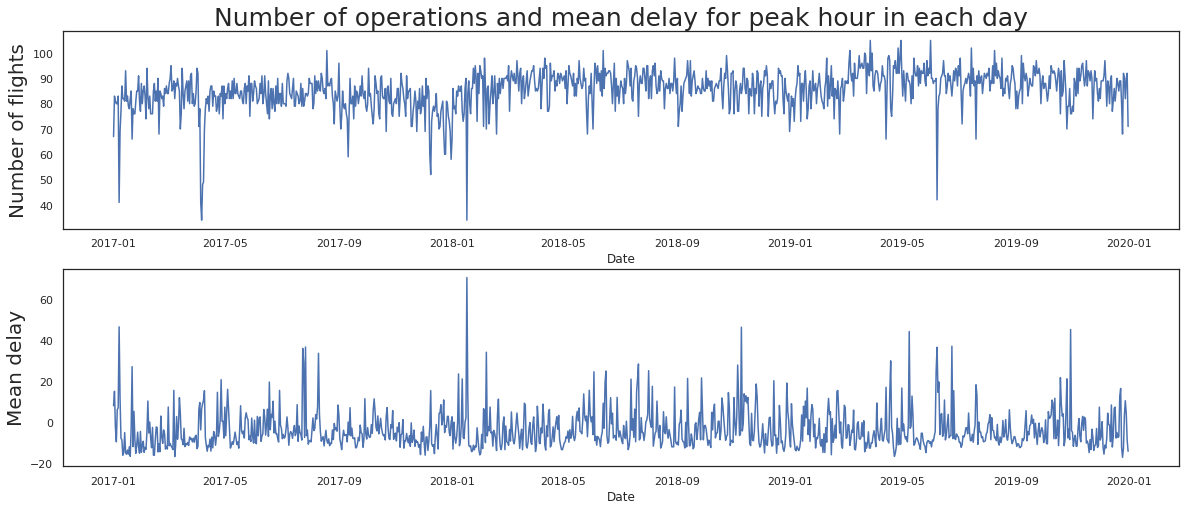

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.lineplot(data=ops_peak_hour_delay, x='FL_DATE', y='count', ax=ax1) 
ax1.axes.set_title("Number of operations and mean delay for peak hour in each day",fontsize=25)
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of flights",fontsize=20)

sns.lineplot(data=ops_peak_hour_delay, x='FL_DATE', y='mean', ax=ax2)
ax2.set_xlabel("Date")
ax2.set_ylabel("Mean delay",fontsize=20)

plt.savefig('peak_hour.png')

plt.show()

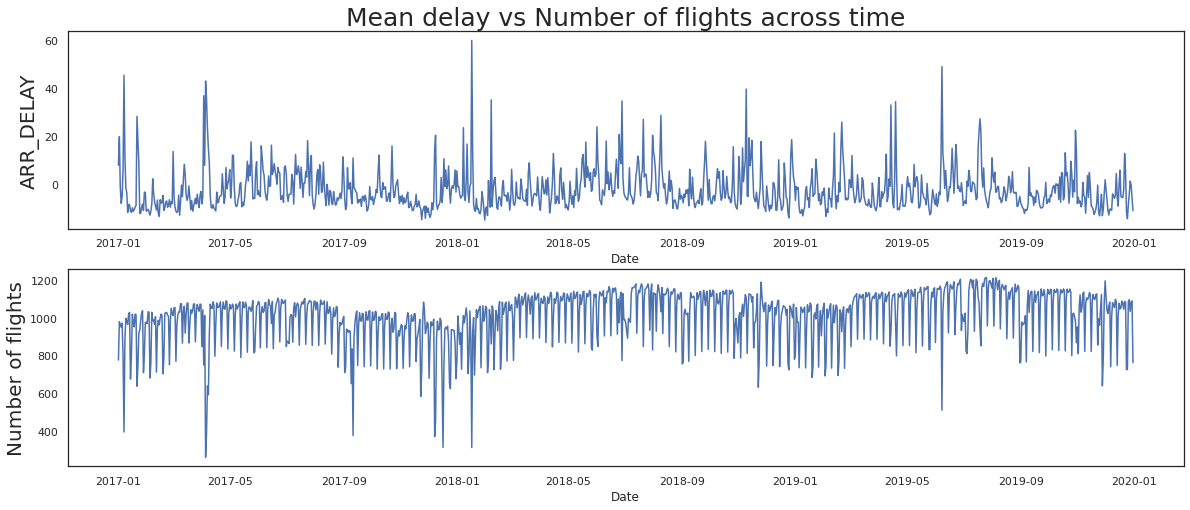

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].mean().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax1) 
ax1.axes.set_title("Mean delay vs Number of flights across time",fontsize=25)
ax1.set_xlabel("Date")
ax1.set_ylabel("ARR_DELAY",fontsize=20)

sns.lineplot(data=df.groupby('FL_DATE')[['ARR_DELAY']].count().reset_index(), x='FL_DATE', y='ARR_DELAY', ax=ax2)
ax2.set_xlabel("Date")
ax2.set_ylabel("Number of flights",fontsize=20)

plt.savefig('nb_flights_hour.png')

plt.show()

In [ ]:
del fig, ax

## Delay types

In [ ]:
carrier_imp = df['CARRIER_DELAY'] / df['ARR_DELAY'] * 100
weather_imp = df['WEATHER_DELAY'] / df['ARR_DELAY'] * 100
nas_imp = df['NAS_DELAY'] / df['ARR_DELAY'] * 100
late_aircraft_imp = df['LATE_AIRCRAFT_DELAY'] / df['ARR_DELAY'] * 100

In [ ]:
type_delay = pd.concat( [carrier_imp.describe(), weather_imp.describe(), nas_imp.describe(), late_aircraft_imp.describe()], axis=1)
type_delay.columns = ['CARRIER_DELAY_pct', 'WEATHER_DELAY_pct', 'NAS_DELAY_pct', 'LATE_AIRCRAFT_DELAY_pct']
type_delay

,CARRIER_DELAY_pct,WEATHER_DELAY_pct,NAS_DELAY_pct,LATE_AIRCRAFT_DELAY_pct
count,149064.000000,149064.000000,149064.000000,149064.000000
mean,24.506205,3.232423,34.548409,37.565049
std,36.552602,15.317954,41.559712,41.754101
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,8.988764,11.111111
75%,40.189207,0.000000,80.952381,84.210526
max,100.000000,100.000000,100.000000,100.000000


## For a given date, month, airline or origin

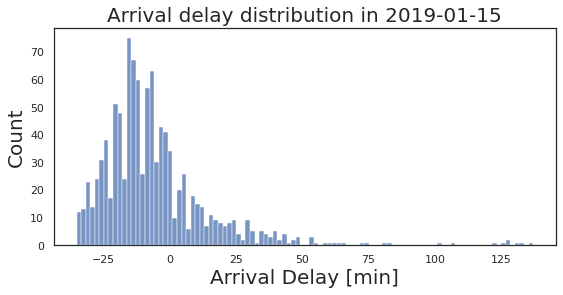

In [ ]:
date_check = '2019-01-15'

sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(9,4))

ax = sns.histplot(data=df[df.FL_DATE == date_check], x='ARR_DELAY', bins=100)
ax.axes.set_title("Arrival delay distribution in "+date_check,fontsize=20)
ax.set_xlabel("Arrival Delay [min]",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

plt.savefig('sample_day.png')

plt.show()

In [ ]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'].astype('string'))

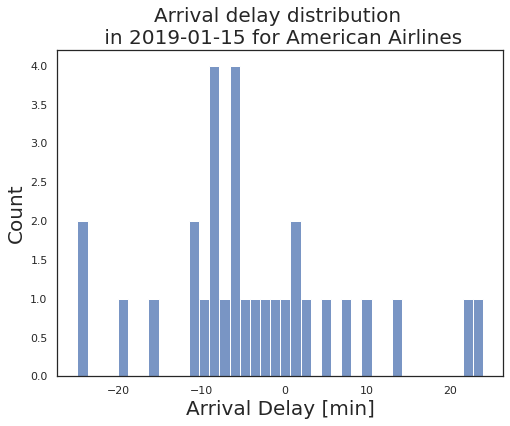

In [ ]:
date_check = '2019-01-15'
carrier = 'AA'

sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,6))

ax = sns.histplot(data=df[(df.FL_DATE == date_check) & (df.OP_UNIQUE_CARRIER == carrier)], x='ARR_DELAY', bins=40)
ax.axes.set_title("Arrival delay distribution \n in "+date_check+' for American Airlines',fontsize=20)
ax.set_xlabel("Arrival Delay [min]",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

plt.savefig('sample_day_airline.png')

plt.show()

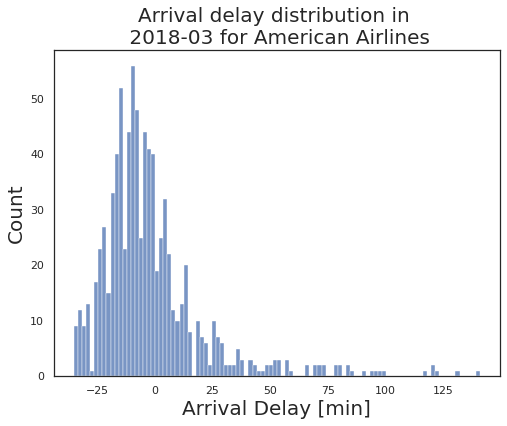

In [ ]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
carrier = 'AA'

sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,6))

ax = sns.histplot(data=df[(df.FL_DATE > date_ini) & (df.FL_DATE <= date_fin) & (df.OP_UNIQUE_CARRIER == carrier)], x='ARR_DELAY', bins=100)
ax.axes.set_title("Arrival delay distribution in \n 2018-03 for American Airlines",fontsize=20)
ax.set_xlabel("Arrival Delay [min]",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

plt.savefig('sample_month_airline.png')

plt.show()

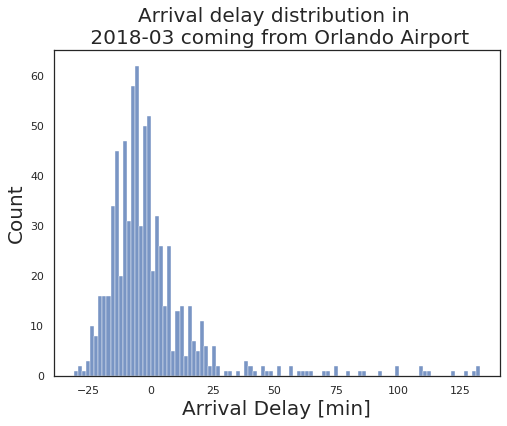

In [ ]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
origin = 'MCO'

sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,6))

ax = sns.histplot(data=df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.ORIGIN == origin)], x='ARR_DELAY', bins=100)
ax.axes.set_title("Arrival delay distribution in \n 2018-03 coming from Orlando Airport",fontsize=20)
ax.set_xlabel("Arrival Delay [min]",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

plt.savefig('sample_origin.png')

plt.show()

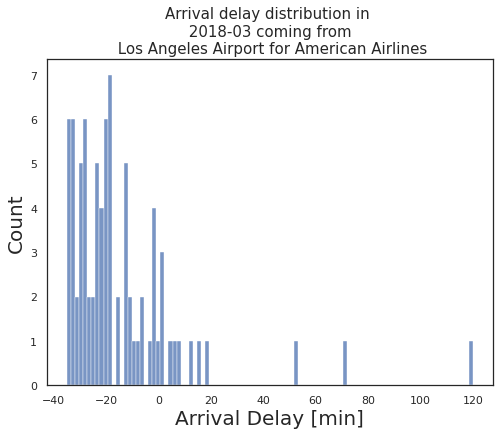

In [ ]:
date_ini = '2018-02-28'
date_fin = '2018-03-28'
carrier = 'AA'
origin = 'LAX'

sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8,6))

ax = sns.histplot(data=df[(df.FL_DATE >= date_ini) & (df.FL_DATE <= date_fin) & (df.OP_UNIQUE_CARRIER == carrier) & (df.ORIGIN == origin)], x='ARR_DELAY', bins=100)
ax.axes.set_title("Arrival delay distribution in \n 2018-03 coming from \n Los Angeles Airport for American Airlines",fontsize=15)
ax.set_xlabel("Arrival Delay [min]",fontsize=20)
ax.set_ylabel("Count",fontsize=20)

plt.savefig('sample_airline_origin.png')

plt.show()